# Fit logistic regression model

- based on different imputation methods
- baseline: reference
- model: any other selected imputation method

In [1]:
import logging
from pathlib import Path
from typing import List

import matplotlib.pyplot as plt
import njab.sklearn
import pandas as pd
import sklearn
from njab.plotting.metrics import plot_split_auc, plot_split_prc
from njab.sklearn.types import Splits

import pimmslearn
import pimmslearn.analyzers
import pimmslearn.io.datasplits

plt.rcParams['figure.figsize'] = (2.5, 2.5)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 2
fontsize = 5
figsize = (2.5, 2.5)
pimmslearn.plotting.make_large_descriptors(fontsize)


logger = pimmslearn.logging.setup_nb_logger()
logging.getLogger('fontTools').setLevel(logging.ERROR)


def parse_roc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _roc = (pd.DataFrame(_r.test.roc,
                             index='fpr tpr cutoffs'.split()
                             )).loc[['fpr', 'tpr']]
        _roc = _roc.T
        _roc.columns = pd.MultiIndex.from_product([[_r.name], _roc.columns])
        ret.append(_roc)
    ret = pd.concat(ret, axis=1)
    return ret


def parse_prc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _prc = pd.DataFrame(_r.test.prc,
                            index='precision recall cutoffs'.split()
                            ).loc[['precision', 'recall']]
        _prc = _prc.T.rename(columns={'recall': 'tpr'})
        _prc.columns = pd.MultiIndex.from_product([[_r.name], _prc.columns])
        ret.append(_prc)
    ret = pd.concat(ret, axis=1)
    return ret


# catch passed parameters
args = None
args = dict(globals()).keys()

## Parameters
Default and set parameters for the notebook.

In [2]:
folder_data: str = ''  # specify data directory if needed
fn_clinical_data = "data/ALD_study/processed/ald_metadata_cli.csv"
folder_experiment = "runs/appl_ald_data/plasma/proteinGroups"
model_key = 'VAE'
target = 'kleiner'
sample_id_col = 'Sample ID'
cutoff_target: int = 2  # => for binarization target >= cutoff_target
file_format = "csv"
out_folder = 'diff_analysis'
fn_qc_samples = ''  # 'data/ALD_study/processed/qc_plasma_proteinGroups.pkl'

baseline = 'RSN'  # default is RSN, as this was used in the original ALD Niu. et. al 2022
template_pred = 'pred_real_na_{}.csv'  # fixed, do not change

In [3]:
# Parameters
cutoff_target = 0.5
folder_experiment = "runs/alzheimer_study"
target = "AD"
baseline = "PI"
model_key = "DAE"
out_folder = "diff_analysis"
fn_clinical_data = "runs/alzheimer_study/data/clinical_data.csv"


In [4]:
params = pimmslearn.nb.get_params(args, globals=globals())
args = pimmslearn.nb.Config()
args.folder_experiment = Path(params["folder_experiment"])
args = pimmslearn.nb.add_default_paths(args,
                                 out_root=(args.folder_experiment
                                           / params["out_folder"]
                                           / params["target"]
                                           / f"{params['baseline']}_vs_{params['model_key']}"))
args.update_from_dict(params)
files_out = dict()
args

root - INFO     Removed from global namespace: folder_data


root - INFO     Removed from global namespace: fn_clinical_data


root - INFO     Removed from global namespace: folder_experiment


root - INFO     Removed from global namespace: model_key


root - INFO     Removed from global namespace: target


root - INFO     Removed from global namespace: sample_id_col


root - INFO     Removed from global namespace: cutoff_target


root - INFO     Removed from global namespace: file_format


root - INFO     Removed from global namespace: out_folder


root - INFO     Removed from global namespace: fn_qc_samples


root - INFO     Removed from global namespace: baseline


root - INFO     Removed from global namespace: template_pred


root - INFO     Already set attribute: folder_experiment has value runs/alzheimer_study


root - INFO     Already set attribute: out_folder has value diff_analysis


{'baseline': 'PI',
 'cutoff_target': 0.5,
 'data': PosixPath('runs/alzheimer_study/data'),
 'file_format': 'csv',
 'fn_clinical_data': 'runs/alzheimer_study/data/clinical_data.csv',
 'fn_qc_samples': '',
 'folder_data': '',
 'folder_experiment': PosixPath('runs/alzheimer_study'),
 'model_key': 'DAE',
 'out_figures': PosixPath('runs/alzheimer_study/figures'),
 'out_folder': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE'),
 'out_metrics': PosixPath('runs/alzheimer_study'),
 'out_models': PosixPath('runs/alzheimer_study'),
 'out_preds': PosixPath('runs/alzheimer_study/preds'),
 'sample_id_col': 'Sample ID',
 'target': 'AD',
 'template_pred': 'pred_real_na_{}.csv'}

## Load data

### Load target

In [5]:
target = pd.read_csv(args.fn_clinical_data,
                     index_col=0,
                     usecols=[args.sample_id_col, args.target])
target = target.dropna()
target

,AD
Sample ID,
Sample_000,0
Sample_001,1
Sample_002,1
Sample_003,1
Sample_004,1
...,...
Sample_205,1
Sample_206,0
Sample_207,0


### MS proteomics or specified omics data
Aggregated from data splits of the imputation workflow run before.

In [6]:
data = pimmslearn.io.datasplits.DataSplits.from_folder(
    args.data, file_format=args.file_format)
data = pd.concat([data.train_X, data.val_y, data.test_y])
data.sample(5)

pimmslearn.io.datasplits - INFO     Loaded 'train_X' from file: runs/alzheimer_study/data/train_X.csv


pimmslearn.io.datasplits - INFO     Loaded 'val_y' from file: runs/alzheimer_study/data/val_y.csv


pimmslearn.io.datasplits - INFO     Loaded 'test_y' from file: runs/alzheimer_study/data/test_y.csv


Sample ID   protein groups                                                           
Sample_160  Q12907                                                                      19.908
Sample_184  H0Y6Q1;O75354;O75354-2;O75354-3;Q5QPI7;Q5QPI9;Q5QPJ3;Q5QPJ4;Q5QPJ6;Q5QPJ7   14.390
Sample_165  Q53EL9;Q53EL9-3                                                             17.783
Sample_017  P43652                                                                      18.709
Sample_164  A0A087WVV2;A0A0A0MRV0;Q9P2E9;Q9P2E9-2;V9GY78                                16.984
Name: intensity, dtype: float64

Get overlap between independent features and target

### Select by ALD criteria
Use parameters as specified in [ALD study](https://github.com/RasmussenLab/pimms/tree/main/project/data/ALD_study).

In [7]:
DATA_COMPLETENESS = 0.6
MIN_N_PROTEIN_GROUPS: int = 200
FRAC_PROTEIN_GROUPS: int = 0.622
CV_QC_SAMPLE: float = 0.4

ald_study, cutoffs = pimmslearn.analyzers.diff_analysis.select_raw_data(data.unstack(
), data_completeness=DATA_COMPLETENESS, frac_protein_groups=FRAC_PROTEIN_GROUPS)

if args.fn_qc_samples:
    qc_samples = pd.read_pickle(args.fn_qc_samples)
    qc_samples = qc_samples[ald_study.columns]
    qc_cv_feat = qc_samples.std() / qc_samples.mean()
    qc_cv_feat = qc_cv_feat.rename(qc_samples.columns.name)
    fig, ax = plt.subplots(figsize=(4, 7))
    ax = qc_cv_feat.plot.box(ax=ax)
    ax.set_ylabel('Coefficient of Variation')
    print((qc_cv_feat < CV_QC_SAMPLE).value_counts())
    ald_study = ald_study[pimmslearn.analyzers.diff_analysis.select_feat(qc_samples)]

column_name_first_prot_to_pg = {
    pg.split(';')[0]: pg for pg in data.unstack().columns}

ald_study = ald_study.rename(columns=column_name_first_prot_to_pg)
ald_study

root - INFO     Initally: N samples: 210, M feat: 1421


root - INFO     Dropped features quantified in less than 126 samples.


root - INFO     After feat selection: N samples: 210, M feat: 1213


root - INFO     Min No. of Protein-Groups in single sample: 754


root - INFO     Finally: N samples: 210, M feat: 1213


protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,NaN,...,16.012,15.178,NaN,15.050,16.842,19.863,NaN,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,NaN,19.067,16.188,...,15.528,15.576,NaN,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,NaN,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,NaN,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,NaN,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,NaN,15.345,17.084,18.708,14.249,19.433,NaN,NaN
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Number of complete cases which can be used:

In [8]:
mask_has_target = data.index.levels[0].intersection(target.index)
assert not mask_has_target.empty, f"No data for target: {data.index.levels[0]} and {target.index}"
print(
    f"Samples available both in proteomics data and for target: {len(mask_has_target)}")
target, data, ald_study = target.loc[mask_has_target], data.loc[mask_has_target], ald_study.loc[mask_has_target]

Samples available both in proteomics data and for target: 210


### Load imputations from specified model

In [9]:
fname = args.out_preds / args.template_pred.format(args.model_key)
print(f"missing values pred. by {args.model_key}: {fname}")
load_single_csv_pred_file = pimmslearn.analyzers.compare_predictions.load_single_csv_pred_file
pred_real_na = load_single_csv_pred_file(fname).loc[mask_has_target]
pred_real_na.sample(3)

missing values pred. by DAE: runs/alzheimer_study/preds/pred_real_na_DAE.csv


Sample ID   protein groups 
Sample_155  P20742            14.128
Sample_033  O00451            13.984
Sample_008  Q8NFP4;Q8NFP4-2   16.849
Name: intensity, dtype: float64

### Load imputations from baseline model

In [10]:
fname = args.out_preds / args.template_pred.format(args.baseline)
pred_real_na_baseline = load_single_csv_pred_file(fname)  # .loc[mask_has_target]
pred_real_na_baseline

Sample ID   protein groups          
Sample_000  A0A075B6J9                 13.162
            A0A075B6Q5                 12.672
            A0A075B6R2                 12.951
            A0A075B6S5                 13.717
            A0A087WSY4                 12.475
                                        ...  
Sample_209  Q9P1W8;Q9P1W8-2;Q9P1W8-4   12.815
            Q9UI40;Q9UI40-2            12.224
            Q9UIW2                     12.635
            Q9UMX0;Q9UMX0-2;Q9UMX0-4   12.487
            Q9UP79                     12.863
Name: intensity, Length: 46401, dtype: float64

## Modeling setup
General approach:
  - use one train, test split of the data
  - select best 10 features from training data `X_train`, `y_train` before binarization of target
  - dichotomize (binarize) data into to groups (zero and 1)
  - evaluate model on the test data `X_test`, `y_test`

Repeat general approach for
 1. all original ald data: all features justed in original ALD study
 2. all model data: all features available my using the self supervised deep learning model
 3. newly available feat only: the subset of features available from the
    self supervised deep learning model which were newly retained using the
    new approach

All data:

In [11]:
X = pd.concat([data, pred_real_na]).unstack()
X

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H7,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,17.301,20.246,16.764,17.584,16.988,20.054,...,16.012,15.178,14.050,15.050,16.842,19.863,16.212,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,13.796,19.941,18.786,17.144,16.363,19.067,...,15.528,15.576,13.946,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,18.175,19.251,16.832,15.671,17.012,18.569,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,15.963,19.628,17.852,18.877,14.182,18.985,...,15.495,14.590,14.682,15.140,17.356,19.429,16.154,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,15.473,20.450,18.682,17.081,14.140,19.686,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,14.281,17.705,17.039,15.063,16.413,19.102,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,14.900,18.154,18.152,16.503,16.860,18.538,...,15.422,16.106,14.478,15.345,17.084,18.708,14.249,19.433,10.935,10.659
Sample_207,15.739,16.877,15.469,16.898,13.422,18.636,17.950,16.321,16.401,18.849,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


### Subset of data by ALD criteria

In [12]:
# could be just observed, drop columns with missing values
ald_study = pd.concat(
    [ald_study.stack(),
     pred_real_na_baseline.loc[
        # only select columns in selected in ald_study
        pd.IndexSlice[:, pred_real_na.index.levels[-1].intersection(ald_study.columns)]
    ]
    ]
).unstack()
ald_study

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6K4,...,O14793,O95479;R4GMU1,P01282;P01282-2,P10619;P10619-2;X6R5C5;X6R8A1,P21810,Q14956;Q14956-2,Q6ZMP0;Q6ZMP0-2,Q9HBW1,Q9NY15,P17050
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,16.148,...,10.939,12.921,12.684,12.284,12.671,13.586,12.769,12.508,13.093,12.786
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,12.057,19.067,16.127,...,12.791,12.794,12.262,13.147,12.633,11.558,12.298,12.476,12.487,13.306
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,15.387,...,12.066,12.743,14.324,13.648,11.850,13.502,14.371,12.735,13.454,12.445
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,16.565,...,12.599,11.254,12.544,14.045,13.113,12.853,11.912,11.564,12.021,12.979
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,16.418,...,14.069,12.635,13.863,13.811,11.939,12.422,13.459,12.935,11.838,12.866
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,11.763,16.413,19.102,15.350,...,14.269,14.064,16.826,18.182,15.225,15.044,14.192,16.605,14.995,14.257
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,16.582,...,14.273,17.700,16.802,20.202,15.280,15.086,13.978,18.086,15.557,14.171
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,15.768,...,14.473,16.882,16.917,20.105,15.690,15.135,13.138,17.066,15.706,15.690


Features which would not have been included using ALD criteria:

In [13]:
new_features = X.columns.difference(ald_study.columns)
new_features

Index(['A0A075B6H7', 'A0A075B6Q5', 'A0A075B7B8', 'A0A087WSY4',
       'A0A087WTT8;A0A0A0MQX5;O94779;O94779-2', 'A0A087WXB8;Q9Y274',
       'A0A087WXE9;E9PQ70;Q6UXH9;Q6UXH9-2;Q6UXH9-3',
       'A0A087X1Z2;C9JTV4;H0Y4Y4;Q8WYH2;Q96C19;Q9BUP0;Q9BUP0-2',
       'A0A0A0MQS9;A0A0A0MTC7;Q16363;Q16363-2', 'A0A0A0MSN4;P12821;P12821-2',
       ...
       'Q9NZ94;Q9NZ94-2;Q9NZ94-3', 'Q9NZU1', 'Q9P1W8;Q9P1W8-2;Q9P1W8-4',
       'Q9UHI8', 'Q9UI40;Q9UI40-2',
       'Q9UIB8;Q9UIB8-2;Q9UIB8-3;Q9UIB8-4;Q9UIB8-5;Q9UIB8-6',
       'Q9UKZ4;Q9UKZ4-2', 'Q9UMX0;Q9UMX0-2;Q9UMX0-4', 'Q9Y281;Q9Y281-3',
       'Q9Y490'],
      dtype='object', name='protein groups', length=208)

Binarize targets, but also keep groups for stratification

In [14]:
target_to_group = target.copy()
target = target >= args.cutoff_target
pd.crosstab(target.squeeze(), target_to_group.squeeze())

AD,0,1
AD,,
False,122,0
True,0,88


## Determine best number of parameters by cross validation procedure

using subset of data by ALD criteria:

In [15]:
cv_feat_ald = njab.sklearn.find_n_best_features(X=ald_study, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_ald = (cv_feat_ald
               .drop('test_case', axis=1)
               .groupby('n_features')
               .agg(['mean', 'std']))
cv_feat_ald

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 388.04it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  8.16it/s]

100%|██████████| 2/2 [00:00<00:00,  8.13it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  5.41it/s]

100%|██████████| 3/3 [00:00<00:00,  3.85it/s]

100%|██████████| 3/3 [00:00<00:00,  4.04it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  8.05it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  6.04it/s]

100%|██████████| 4/4 [00:00<00:00,  4.58it/s]

100%|██████████| 4/4 [00:00<00:00,  5.12it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  7.28it/s]

 60%|██████    | 3/5 [00:00<00:00,  4.61it/s]

 80%|████████  | 4/5 [00:00<00:00,  3.93it/s]

100%|██████████| 5/5 [00:01<00:00,  3.90it/s]

100%|██████████| 5/5 [00:01<00:00,  4.24it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  8.28it/s]

 50%|█████     | 3/6 [00:00<00:00,  5.84it/s]

 67%|██████▋   | 4/6 [00:00<00:00,  3.80it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.25it/s]

100%|██████████| 6/6 [00:01<00:00,  3.06it/s]

100%|██████████| 6/6 [00:01<00:00,  3.62it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  7.58it/s]

 43%|████▎     | 3/7 [00:00<00:00,  4.97it/s]

 57%|█████▋    | 4/7 [00:00<00:00,  4.62it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  4.01it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  3.99it/s]

100%|██████████| 7/7 [00:01<00:00,  4.03it/s]

100%|██████████| 7/7 [00:01<00:00,  4.34it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:01,  5.79it/s]

 38%|███▊      | 3/8 [00:00<00:01,  4.07it/s]

 50%|█████     | 4/8 [00:01<00:01,  2.91it/s]

 62%|██████▎   | 5/8 [00:01<00:01,  2.65it/s]

 75%|███████▌  | 6/8 [00:02<00:00,  2.60it/s]

 88%|████████▊ | 7/8 [00:02<00:00,  2.48it/s]

100%|██████████| 8/8 [00:02<00:00,  2.32it/s]

100%|██████████| 8/8 [00:02<00:00,  2.68it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  4.74it/s]

 33%|███▎      | 3/9 [00:00<00:01,  3.46it/s]

 44%|████▍     | 4/9 [00:01<00:01,  3.06it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  2.82it/s]

 67%|██████▋   | 6/9 [00:02<00:01,  2.66it/s]

 78%|███████▊  | 7/9 [00:02<00:00,  2.51it/s]

 89%|████████▉ | 8/9 [00:02<00:00,  2.46it/s]

100%|██████████| 9/9 [00:03<00:00,  2.40it/s]

100%|██████████| 9/9 [00:03<00:00,  2.68it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:00,  9.69it/s]

 30%|███       | 3/10 [00:00<00:01,  6.70it/s]

 40%|████      | 4/10 [00:00<00:01,  5.69it/s]

 50%|█████     | 5/10 [00:00<00:00,  5.13it/s]

 60%|██████    | 6/10 [00:01<00:00,  4.92it/s]

 70%|███████   | 7/10 [00:01<00:00,  4.75it/s]

 80%|████████  | 8/10 [00:01<00:00,  4.83it/s]

 90%|█████████ | 9/10 [00:01<00:00,  3.94it/s]

100%|██████████| 10/10 [00:02<00:00,  4.15it/s]

100%|██████████| 10/10 [00:02<00:00,  4.79it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  8.95it/s]

 27%|██▋       | 3/11 [00:00<00:00,  8.27it/s]

 36%|███▋      | 4/11 [00:00<00:00,  7.73it/s]

 45%|████▌     | 5/11 [00:00<00:00,  7.03it/s]

 55%|█████▍    | 6/11 [00:00<00:00,  6.44it/s]

 64%|██████▎   | 7/11 [00:01<00:00,  5.05it/s]

 73%|███████▎  | 8/11 [00:01<00:00,  4.87it/s]

 82%|████████▏ | 9/11 [00:01<00:00,  4.94it/s]

 91%|█████████ | 10/11 [00:01<00:00,  5.11it/s]

100%|██████████| 11/11 [00:01<00:00,  5.54it/s]

100%|██████████| 11/11 [00:01<00:00,  5.85it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  8.87it/s]

 25%|██▌       | 3/12 [00:00<00:01,  5.85it/s]

 33%|███▎      | 4/12 [00:00<00:01,  4.97it/s]

 42%|████▏     | 5/12 [00:01<00:01,  4.14it/s]

 50%|█████     | 6/12 [00:01<00:01,  4.09it/s]

 58%|█████▊    | 7/12 [00:01<00:01,  4.65it/s]

 67%|██████▋   | 8/12 [00:01<00:00,  4.66it/s]

 75%|███████▌  | 9/12 [00:01<00:00,  4.55it/s]

 83%|████████▎ | 10/12 [00:02<00:00,  4.59it/s]

 92%|█████████▏| 11/12 [00:02<00:00,  4.48it/s]

100%|██████████| 12/12 [00:02<00:00,  4.37it/s]

100%|██████████| 12/12 [00:02<00:00,  4.64it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:01,  9.03it/s]

 23%|██▎       | 3/13 [00:00<00:01,  5.37it/s]

 31%|███       | 4/13 [00:00<00:01,  4.86it/s]

 38%|███▊      | 5/13 [00:01<00:01,  4.49it/s]

 46%|████▌     | 6/13 [00:01<00:01,  4.40it/s]

 54%|█████▍    | 7/13 [00:01<00:01,  4.46it/s]

 62%|██████▏   | 8/13 [00:01<00:01,  4.45it/s]

 69%|██████▉   | 9/13 [00:01<00:00,  4.60it/s]

 77%|███████▋  | 10/13 [00:02<00:00,  4.63it/s]

 85%|████████▍ | 11/13 [00:02<00:00,  4.51it/s]

 92%|█████████▏| 12/13 [00:02<00:00,  4.61it/s]

100%|██████████| 13/13 [00:02<00:00,  4.53it/s]

100%|██████████| 13/13 [00:02<00:00,  4.69it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:01, 11.07it/s]

 29%|██▊       | 4/14 [00:00<00:01,  5.17it/s]

 36%|███▌      | 5/14 [00:01<00:02,  4.43it/s]

 43%|████▎     | 6/14 [00:01<00:01,  4.23it/s]

 50%|█████     | 7/14 [00:01<00:01,  4.35it/s]

 57%|█████▋    | 8/14 [00:01<00:01,  4.34it/s]

 64%|██████▍   | 9/14 [00:01<00:01,  4.24it/s]

 71%|███████▏  | 10/14 [00:02<00:00,  4.27it/s]

 79%|███████▊  | 11/14 [00:02<00:00,  4.32it/s]

 86%|████████▌ | 12/14 [00:02<00:00,  4.41it/s]

 93%|█████████▎| 13/14 [00:02<00:00,  4.33it/s]

100%|██████████| 14/14 [00:03<00:00,  4.37it/s]

100%|██████████| 14/14 [00:03<00:00,  4.50it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:01,  8.66it/s]

 20%|██        | 3/15 [00:00<00:02,  4.86it/s]

 27%|██▋       | 4/15 [00:00<00:02,  4.67it/s]

 33%|███▎      | 5/15 [00:01<00:02,  4.42it/s]

 40%|████      | 6/15 [00:01<00:02,  4.37it/s]

 47%|████▋     | 7/15 [00:01<00:01,  4.29it/s]

 53%|█████▎    | 8/15 [00:01<00:01,  4.42it/s]

 60%|██████    | 9/15 [00:01<00:01,  4.39it/s]

 67%|██████▋   | 10/15 [00:02<00:01,  4.29it/s]

 73%|███████▎  | 11/15 [00:02<00:00,  4.46it/s]

 80%|████████  | 12/15 [00:02<00:00,  4.44it/s]

 87%|████████▋ | 13/15 [00:02<00:00,  4.36it/s]

 93%|█████████▎| 14/15 [00:03<00:00,  4.19it/s]

100%|██████████| 15/15 [00:03<00:00,  4.34it/s]

100%|██████████| 15/15 [00:03<00:00,  4.48it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.004 0.004      0.051 0.021          0.736 0.369       0.110   
2             0.005 0.007      0.045 0.016          0.707 0.091       0.603   
3             0.004 0.003      0.047 0.016          0.720 0.086       0.659   
4             0.004 0.002      0.042 0.014          0.706 0.081       0.676   
5             0.004 0.002      0.045 0.014          0.721 0.089       0.690   
6             0.005 0.004      0.050 0.017          0.804 0.092       0.815   
7             0.005 0.004      0.047 0.021          0.799 0.084       0.825   
8             0.006 0.005      0.052 0.022          0.793 0.087       0.798   
9             0.006 0.005      0.058 0.027          0.786 0.087       0.795   
10            0.003 0.000      0.034 0.008          0.812 0.083       0.809   
11            0.004 0.000      0.039 0.010          0.812 0.086       0.816   
12            0.004 0.002      0.036 0.006          0.797 0.084       0.821   
13            0.003 0.002      0.032 0.008          0.816 0.083       0.814   
14            0.004 0.002      0.037 0.004          0.808 0.086       0.805   
15            0.004 0.001      0.037 0.006          0.802 0.083       0.805   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.083   0.184 0.127                  0.548 0.040        0.852   
2          0.106   0.645 0.080                  0.708 0.060        0.781   
3          0.116   0.681 0.082                  0.734 0.060        0.801   
4          0.112   0.684 0.073                  0.733 0.054        0.797   
5          0.114   0.698 0.076                  0.745 0.059        0.807   
6          0.109   0.804 0.078                  0.833 0.066        0.892   
7          0.105   0.807 0.071                  0.835 0.061        0.891   
8          0.109   0.790 0.074                  0.821 0.063        0.892   
9          0.109   0.786 0.074                  0.817 0.063        0.891   
10         0.106   0.806 0.072                  0.835 0.062        0.905   
11         0.105   0.810 0.073                  0.837 0.062        0.906   
12         0.106   0.805 0.076                  0.833 0.066        0.907   
13         0.091   0.811 0.064                  0.838 0.054        0.913   
14         0.091   0.802 0.065                  0.831 0.055        0.911   
15         0.091   0.799 0.064                  0.828 0.054        0.909   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.066                  0.824 0.089        210.000 0.000  
2          0.069                  0.759 0.086        210.000 0.000  
3          0.069                  0.768 0.089        210.000 0.000  
4          0.063                  0.759 0.084        210.000 0.000  
5          0.063                  0.778 0.084        210.000 0.000  
6          0.056                  0.863 0.064        210.000 0.000  
7          0.055                  0.862 0.064        210.000 0.000  
8          0.054                  0.862 0.067        210.000 0.000  
9          0.056                  0.862 0.065        210.000 0.000  
10         0.055                  0.890 0.057        210.000 0.000  
11         0.055                  0.892 0.057        210.000 0.000  
12         0.054                  0.898 0.051        210.000 0.000  
13         0.052                  0.904 0.049        210.000 0.000  
14         0.052                  0.902 0.050        210.000 0.000  
15         0.051                  0.901 0.049 

Using all data:

In [16]:
cv_feat_all = njab.sklearn.find_n_best_features(X=X, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_all = cv_feat_all.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_all

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 467.18it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  5.96it/s]

100%|██████████| 2/2 [00:00<00:00,  5.95it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  6.88it/s]

100%|██████████| 3/3 [00:00<00:00,  4.98it/s]

100%|██████████| 3/3 [00:00<00:00,  5.27it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  4.87it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  3.38it/s]

100%|██████████| 4/4 [00:01<00:00,  2.94it/s]

100%|██████████| 4/4 [00:01<00:00,  3.17it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  4.99it/s]

 60%|██████    | 3/5 [00:00<00:00,  4.14it/s]

 80%|████████  | 4/5 [00:00<00:00,  3.91it/s]

100%|██████████| 5/5 [00:01<00:00,  3.71it/s]

100%|██████████| 5/5 [00:01<00:00,  3.92it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  6.00it/s]

 50%|█████     | 3/6 [00:00<00:00,  4.64it/s]

 67%|██████▋   | 4/6 [00:00<00:00,  4.10it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.91it/s]

100%|██████████| 6/6 [00:01<00:00,  3.95it/s]

100%|██████████| 6/6 [00:01<00:00,  4.18it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  7.31it/s]

 43%|████▎     | 3/7 [00:00<00:00,  5.37it/s]

 57%|█████▋    | 4/7 [00:00<00:00,  4.56it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  4.31it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  4.10it/s]

100%|██████████| 7/7 [00:01<00:00,  4.15it/s]

100%|██████████| 7/7 [00:01<00:00,  4.48it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:00,  9.19it/s]

 38%|███▊      | 3/8 [00:00<00:00,  6.17it/s]

 50%|█████     | 4/8 [00:00<00:00,  5.31it/s]

 62%|██████▎   | 5/8 [00:00<00:00,  4.82it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  4.27it/s]

 88%|████████▊ | 7/8 [00:01<00:00,  4.30it/s]

100%|██████████| 8/8 [00:01<00:00,  4.25it/s]

100%|██████████| 8/8 [00:01<00:00,  4.73it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  5.16it/s]

 33%|███▎      | 3/9 [00:00<00:01,  3.65it/s]

 44%|████▍     | 4/9 [00:01<00:01,  3.18it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  2.87it/s]

 67%|██████▋   | 6/9 [00:01<00:01,  2.77it/s]

 78%|███████▊  | 7/9 [00:02<00:00,  2.69it/s]

 89%|████████▉ | 8/9 [00:02<00:00,  2.72it/s]

100%|██████████| 9/9 [00:02<00:00,  2.93it/s]

100%|██████████| 9/9 [00:02<00:00,  3.01it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:00,  8.02it/s]

 30%|███       | 3/10 [00:00<00:01,  5.72it/s]

 40%|████      | 4/10 [00:00<00:01,  4.90it/s]

 50%|█████     | 5/10 [00:01<00:01,  4.16it/s]

 60%|██████    | 6/10 [00:01<00:01,  3.33it/s]

 70%|███████   | 7/10 [00:01<00:00,  3.14it/s]

 80%|████████  | 8/10 [00:02<00:00,  2.91it/s]

 90%|█████████ | 9/10 [00:02<00:00,  2.72it/s]

100%|██████████| 10/10 [00:03<00:00,  2.47it/s]

100%|██████████| 10/10 [00:03<00:00,  3.17it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  5.04it/s]

 27%|██▋       | 3/11 [00:00<00:02,  3.56it/s]

 36%|███▋      | 4/11 [00:01<00:02,  2.80it/s]

 45%|████▌     | 5/11 [00:01<00:02,  2.58it/s]

 55%|█████▍    | 6/11 [00:02<00:01,  2.55it/s]

 64%|██████▎   | 7/11 [00:02<00:01,  2.51it/s]

 73%|███████▎  | 8/11 [00:02<00:01,  2.45it/s]

 82%|████████▏ | 9/11 [00:03<00:00,  2.68it/s]

 91%|█████████ | 10/11 [00:03<00:00,  2.85it/s]

100%|██████████| 11/11 [00:03<00:00,  3.13it/s]

100%|██████████| 11/11 [00:03<00:00,  2.88it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  7.32it/s]

 25%|██▌       | 3/12 [00:00<00:01,  4.86it/s]

 33%|███▎      | 4/12 [00:00<00:01,  4.55it/s]

 42%|████▏     | 5/12 [00:01<00:01,  4.20it/s]

 50%|█████     | 6/12 [00:01<00:01,  3.78it/s]

 58%|█████▊    | 7/12 [00:01<00:01,  3.26it/s]

 67%|██████▋   | 8/12 [00:02<00:01,  2.91it/s]

 75%|███████▌  | 9/12 [00:02<00:01,  2.59it/s]

 83%|████████▎ | 10/12 [00:03<00:00,  2.35it/s]

 92%|█████████▏| 11/12 [00:03<00:00,  2.29it/s]

100%|██████████| 12/12 [00:04<00:00,  2.42it/s]

100%|██████████| 12/12 [00:04<00:00,  2.96it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:02,  4.16it/s]

 23%|██▎       | 3/13 [00:00<00:03,  3.13it/s]

 31%|███       | 4/13 [00:01<00:03,  2.88it/s]

 38%|███▊      | 5/13 [00:01<00:02,  2.94it/s]

 46%|████▌     | 6/13 [00:01<00:02,  2.89it/s]

 54%|█████▍    | 7/13 [00:02<00:02,  2.72it/s]

 62%|██████▏   | 8/13 [00:02<00:01,  2.92it/s]

 69%|██████▉   | 9/13 [00:02<00:01,  3.21it/s]

 77%|███████▋  | 10/13 [00:03<00:00,  3.42it/s]

 85%|████████▍ | 11/13 [00:03<00:00,  3.56it/s]

 92%|█████████▏| 12/13 [00:03<00:00,  3.68it/s]

100%|██████████| 13/13 [00:03<00:00,  3.67it/s]

100%|██████████| 13/13 [00:03<00:00,  3.28it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:01,  8.07it/s]

 21%|██▏       | 3/14 [00:00<00:01,  5.61it/s]

 29%|██▊       | 4/14 [00:00<00:02,  4.81it/s]

 36%|███▌      | 5/14 [00:01<00:02,  4.35it/s]

 43%|████▎     | 6/14 [00:01<00:02,  4.00it/s]

 50%|█████     | 7/14 [00:01<00:01,  3.74it/s]

 57%|█████▋    | 8/14 [00:02<00:01,  3.30it/s]

 64%|██████▍   | 9/14 [00:02<00:01,  2.97it/s]

 71%|███████▏  | 10/14 [00:02<00:01,  2.93it/s]

 79%|███████▊  | 11/14 [00:03<00:01,  2.61it/s]

 86%|████████▌ | 12/14 [00:03<00:00,  2.41it/s]

 93%|█████████▎| 13/14 [00:04<00:00,  2.21it/s]

100%|██████████| 14/14 [00:04<00:00,  2.27it/s]

100%|██████████| 14/14 [00:04<00:00,  2.98it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  4.65it/s]

 20%|██        | 3/15 [00:00<00:03,  3.44it/s]

 27%|██▋       | 4/15 [00:01<00:03,  2.78it/s]

 33%|███▎      | 5/15 [00:01<00:03,  2.69it/s]

 40%|████      | 6/15 [00:02<00:03,  2.50it/s]

 47%|████▋     | 7/15 [00:02<00:03,  2.45it/s]

 53%|█████▎    | 8/15 [00:02<00:02,  2.59it/s]

 60%|██████    | 9/15 [00:03<00:02,  2.66it/s]

 67%|██████▋   | 10/15 [00:03<00:01,  2.61it/s]

 73%|███████▎  | 11/15 [00:04<00:01,  2.71it/s]

 80%|████████  | 12/15 [00:04<00:01,  2.68it/s]

 87%|████████▋ | 13/15 [00:04<00:00,  2.86it/s]

 93%|█████████▎| 14/15 [00:05<00:00,  2.83it/s]

100%|██████████| 15/15 [00:05<00:00,  2.93it/s]

100%|██████████| 15/15 [00:05<00:00,  2.79it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.003 0.000      0.038 0.007          0.158 0.330       0.020   
2             0.003 0.000      0.037 0.005          0.646 0.168       0.313   
3             0.003 0.000      0.036 0.001          0.688 0.095       0.625   
4             0.004 0.003      0.045 0.016          0.716 0.090       0.673   
5             0.005 0.004      0.046 0.016          0.724 0.097       0.666   
6             0.003 0.000      0.033 0.003          0.775 0.089       0.706   
7             0.003 0.000      0.028 0.004          0.778 0.093       0.707   
8             0.003 0.000      0.032 0.002          0.797 0.088       0.810   
9             0.004 0.002      0.038 0.017          0.794 0.085       0.807   
10            0.006 0.006      0.053 0.024          0.788 0.089       0.801   
11            0.005 0.004      0.058 0.027          0.789 0.086       0.808   
12            0.004 0.001      0.041 0.014          0.815 0.083       0.801   
13            0.006 0.005      0.058 0.028          0.802 0.082       0.801   
14            0.005 0.005      0.041 0.012          0.807 0.087       0.808   
15            0.006 0.005      0.052 0.018          0.818 0.082       0.812   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.048   0.034 0.079                  0.505 0.021        0.870   
2          0.121   0.404 0.114                  0.585 0.060        0.688   
3          0.106   0.650 0.086                  0.707 0.067        0.792   
4          0.123   0.687 0.086                  0.737 0.065        0.822   
5          0.122   0.687 0.090                  0.738 0.068        0.818   
6          0.096   0.734 0.073                  0.776 0.057        0.843   
7          0.094   0.736 0.074                  0.778 0.059        0.844   
8          0.103   0.798 0.068                  0.827 0.057        0.909   
9          0.098   0.795 0.066                  0.825 0.055        0.907   
10         0.100   0.789 0.068                  0.819 0.057        0.904   
11         0.100   0.792 0.062                  0.822 0.052        0.904   
12         0.103   0.803 0.068                  0.832 0.058        0.914   
13         0.103   0.797 0.067                  0.827 0.057        0.913   
14         0.098   0.803 0.069                  0.832 0.058        0.916   
15         0.096   0.810 0.064                  0.838 0.053        0.925   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.060                  0.838 0.087        210.000 0.000  
2          0.084                  0.615 0.101        210.000 0.000  
3          0.063                  0.739 0.092        210.000 0.000  
4          0.055                  0.794 0.073        210.000 0.000  
5          0.057                  0.792 0.074        210.000 0.000  
6          0.054                  0.814 0.070        210.000 0.000  
7          0.058                  0.817 0.072        210.000 0.000  
8          0.045                  0.889 0.054        210.000 0.000  
9          0.047                  0.886 0.055        210.000 0.000  
10         0.047                  0.884 0.054        210.000 0.000  
11         0.047                  0.883 0.054        210.000 0.000  
12         0.045                  0.894 0.052        210.000 0.000  
13         0.045                  0.893 0.052        210.000 0.000  
14         0.044                  0.896 0.050        210.000 0.000  
15         0.040                  0.909 0.045 

Using only new features:

In [17]:
cv_feat_new = njab.sklearn.find_n_best_features(X=X.loc[:, new_features],
                                                y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_new = cv_feat_new.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_new

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 1118.78it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 34.49it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00, 23.97it/s]

100%|██████████| 3/3 [00:00<00:00, 22.84it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 19.81it/s]

100%|██████████| 4/4 [00:00<00:00, 17.68it/s]

100%|██████████| 4/4 [00:00<00:00, 17.82it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 60%|██████    | 3/5 [00:00<00:00, 19.59it/s]

100%|██████████| 5/5 [00:00<00:00, 15.01it/s]

100%|██████████| 5/5 [00:00<00:00, 15.64it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 50%|█████     | 3/6 [00:00<00:00, 23.20it/s]

100%|██████████| 6/6 [00:00<00:00, 16.45it/s]

100%|██████████| 6/6 [00:00<00:00, 17.16it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 43%|████▎     | 3/7 [00:00<00:00, 20.74it/s]

 86%|████████▌ | 6/7 [00:00<00:00, 14.23it/s]

100%|██████████| 7/7 [00:00<00:00, 13.90it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 38%|███▊      | 3/8 [00:00<00:00, 23.90it/s]

 75%|███████▌  | 6/8 [00:00<00:00, 15.92it/s]

100%|██████████| 8/8 [00:00<00:00, 15.23it/s]

100%|██████████| 8/8 [00:00<00:00, 15.74it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 33%|███▎      | 3/9 [00:00<00:00, 17.76it/s]

 56%|█████▌    | 5/9 [00:00<00:00, 12.40it/s]

 78%|███████▊  | 7/9 [00:00<00:00, 11.71it/s]

100%|██████████| 9/9 [00:00<00:00, 11.85it/s]

100%|██████████| 9/9 [00:00<00:00, 12.16it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 30%|███       | 3/10 [00:00<00:00, 16.70it/s]

 50%|█████     | 5/10 [00:00<00:00, 15.62it/s]

 70%|███████   | 7/10 [00:00<00:00, 15.34it/s]

 90%|█████████ | 9/10 [00:00<00:00, 14.06it/s]

100%|██████████| 10/10 [00:00<00:00, 14.53it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 27%|██▋       | 3/11 [00:00<00:00, 20.79it/s]

 55%|█████▍    | 6/11 [00:00<00:00, 15.05it/s]

 73%|███████▎  | 8/11 [00:00<00:00, 13.19it/s]

 91%|█████████ | 10/11 [00:00<00:00, 13.25it/s]

100%|██████████| 11/11 [00:00<00:00, 13.79it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 25%|██▌       | 3/12 [00:00<00:00, 26.17it/s]

 50%|█████     | 6/12 [00:00<00:00, 16.77it/s]

 67%|██████▋   | 8/12 [00:00<00:00, 15.87it/s]

 83%|████████▎ | 10/12 [00:00<00:00, 14.71it/s]

100%|██████████| 12/12 [00:00<00:00, 13.78it/s]

100%|██████████| 12/12 [00:00<00:00, 15.04it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 23%|██▎       | 3/13 [00:00<00:00, 26.54it/s]

 46%|████▌     | 6/13 [00:00<00:00, 16.34it/s]

 62%|██████▏   | 8/13 [00:00<00:00, 14.89it/s]

 77%|███████▋  | 10/13 [00:00<00:00, 14.84it/s]

 92%|█████████▏| 12/13 [00:00<00:00, 13.77it/s]

100%|██████████| 13/13 [00:00<00:00, 14.64it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 21%|██▏       | 3/14 [00:00<00:00, 20.30it/s]

 43%|████▎     | 6/14 [00:00<00:00, 17.90it/s]

 57%|█████▋    | 8/14 [00:00<00:00, 16.86it/s]

 71%|███████▏  | 10/14 [00:00<00:00, 16.74it/s]

 86%|████████▌ | 12/14 [00:00<00:00, 16.54it/s]

100%|██████████| 14/14 [00:00<00:00, 15.05it/s]

100%|██████████| 14/14 [00:00<00:00, 15.85it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 20%|██        | 3/15 [00:00<00:00, 17.79it/s]

 33%|███▎      | 5/15 [00:00<00:00, 14.19it/s]

 47%|████▋     | 7/15 [00:00<00:00, 12.65it/s]

 60%|██████    | 9/15 [00:00<00:00, 13.11it/s]

 73%|███████▎  | 11/15 [00:00<00:00, 12.93it/s]

 87%|████████▋ | 13/15 [00:00<00:00, 13.16it/s]

100%|██████████| 15/15 [00:01<00:00, 13.55it/s]

100%|██████████| 15/15 [00:01<00:00, 13.38it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.006 0.004      0.047 0.020          0.000 0.000       0.000   
2             0.004 0.003      0.052 0.018          0.646 0.142       0.354   
3             0.005 0.006      0.050 0.020          0.630 0.133       0.386   
4             0.005 0.004      0.046 0.017          0.608 0.133       0.385   
5             0.006 0.005      0.052 0.019          0.665 0.104       0.582   
6             0.005 0.004      0.048 0.017          0.663 0.112       0.565   
7             0.005 0.003      0.054 0.027          0.698 0.092       0.660   
8             0.004 0.002      0.047 0.017          0.697 0.090       0.663   
9             0.004 0.003      0.053 0.022          0.682 0.085       0.675   
10            0.004 0.003      0.048 0.015          0.674 0.086       0.653   
11            0.006 0.007      0.053 0.028          0.686 0.083       0.656   
12            0.006 0.005      0.064 0.030          0.680 0.085       0.652   
13            0.005 0.004      0.049 0.020          0.677 0.085       0.659   
14            0.006 0.005      0.062 0.018          0.683 0.076       0.661   
15            0.005 0.004      0.044 0.015          0.675 0.082       0.657   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.000   0.000 0.000                  0.500 0.000        0.726   
2          0.081   0.451 0.087                  0.602 0.057        0.646   
3          0.098   0.469 0.085                  0.604 0.059        0.658   
4          0.108   0.461 0.094                  0.596 0.063        0.651   
5          0.117   0.613 0.089                  0.682 0.066        0.768   
6          0.117   0.603 0.092                  0.675 0.068        0.767   
7          0.112   0.673 0.083                  0.724 0.066        0.800   
8          0.111   0.674 0.083                  0.725 0.066        0.796   
9          0.106   0.674 0.078                  0.722 0.063        0.812   
10         0.105   0.658 0.074                  0.709 0.060        0.809   
11         0.109   0.665 0.078                  0.717 0.061        0.809   
12         0.109   0.661 0.079                  0.713 0.063        0.805   
13         0.114   0.663 0.087                  0.714 0.070        0.807   
14         0.110   0.667 0.081                  0.718 0.064        0.805   
15         0.114   0.661 0.085                  0.713 0.068        0.801   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.067                  0.684 0.082        210.000 0.000  
2          0.074                  0.614 0.078        210.000 0.000  
3          0.077                  0.622 0.082        210.000 0.000  
4          0.077                  0.609 0.086        210.000 0.000  
5          0.074                  0.713 0.097        210.000 0.000  
6          0.076                  0.715 0.095        210.000 0.000  
7          0.067                  0.746 0.082        210.000 0.000  
8          0.065                  0.742 0.079        210.000 0.000  
9          0.065                  0.762 0.083        210.000 0.000  
10         0.066                  0.757 0.083        210.000 0.000  
11         0.063                  0.755 0.084        210.000 0.000  
12         0.063                  0.747 0.083        210.000 0.000  
13         0.065                  0.743 0.087        210.000 0.000  
14         0.061                  0.742 0.083        210.000 0.000  
15         0.064                  0.737 0.086 

### Best number of features by subset of the data:

In [18]:
n_feat_best = pd.DataFrame(
    {'ald': cv_feat_ald.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'all': cv_feat_all.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'new': cv_feat_new.loc[:, pd.IndexSlice[:, 'mean']].idxmax()
     }
).droplevel(-1)
n_feat_best

,ald,all,new
fit_time,9,13,14
score_time,9,13,12
test_precision,13,15,7
test_recall,7,15,9
test_f1,13,15,8
test_balanced_accuracy,13,15,8
test_roc_auc,13,15,9
test_average_precision,13,15,9
n_observations,1,1,1


## Train, test split
Show number of cases in train and test data

In [19]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X,
    target,
    test_size=.2,
    stratify=target_to_group,
    random_state=42)
idx_train = X_train.index
idx_test = X_test.index

njab.pandas.combine_value_counts(
    pd.concat([y_train, y_test],
              axis=1,
              ignore_index=True,
              ).rename(columns={0: 'train', 1: 'test'})
)

,train,test
False,98,24
True,70,18


## Results

- `run_model` returns dataclasses with the further needed results
- add mrmr selection of data (select best number of features to use instead of fixing it)

Save results for final model on entire data, new features and ALD study criteria selected data.

In [20]:
splits = Splits(X_train=X.loc[idx_train],
                X_test=X.loc[idx_test],
                y_train=y_train,
                y_test=y_test)
results_model_full = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'all'])
results_model_full.name = f'{args.model_key} all'
fname = args.out_folder / f'results_{results_model_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_full, fname)

splits = Splits(X_train=X.loc[idx_train, new_features],
                X_test=X.loc[idx_test, new_features],
                y_train=y_train,
                y_test=y_test)
results_model_new = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'new'])
results_model_new.name = f'{args.model_key} new'
fname = args.out_folder / f'results_{results_model_new.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_new, fname)

splits_ald = Splits(
    X_train=ald_study.loc[idx_train],
    X_test=ald_study.loc[idx_test],
    y_train=y_train,
    y_test=y_test)
results_ald_full = njab.sklearn.run_model(
    splits_ald,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'ald'])
results_ald_full.name = 'ALD study all'
fname = args.out_folder / f'results_{results_ald_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_ald_full, fname)

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  5.90it/s]

 20%|██        | 3/15 [00:00<00:02,  4.52it/s]

 27%|██▋       | 4/15 [00:00<00:02,  4.08it/s]

 33%|███▎      | 5/15 [00:01<00:02,  4.05it/s]

 40%|████      | 6/15 [00:01<00:02,  3.91it/s]

 47%|████▋     | 7/15 [00:01<00:01,  4.01it/s]

 53%|█████▎    | 8/15 [00:01<00:01,  4.09it/s]

 60%|██████    | 9/15 [00:02<00:01,  4.01it/s]

 67%|██████▋   | 10/15 [00:02<00:01,  3.75it/s]

 73%|███████▎  | 11/15 [00:02<00:01,  3.37it/s]

 80%|████████  | 12/15 [00:03<00:00,  3.03it/s]

 87%|████████▋ | 13/15 [00:03<00:00,  2.83it/s]

 93%|█████████▎| 14/15 [00:04<00:00,  2.43it/s]

100%|██████████| 15/15 [00:04<00:00,  2.22it/s]

100%|██████████| 15/15 [00:04<00:00,  3.16it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 33%|███▎      | 3/9 [00:00<00:00, 18.21it/s]

 56%|█████▌    | 5/9 [00:00<00:00, 14.22it/s]

 78%|███████▊  | 7/9 [00:00<00:00, 13.45it/s]

100%|██████████| 9/9 [00:00<00:00, 13.80it/s]

100%|██████████| 9/9 [00:00<00:00, 14.10it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:01,  8.68it/s]

 23%|██▎       | 3/13 [00:00<00:01,  6.11it/s]

 31%|███       | 4/13 [00:00<00:01,  5.46it/s]

 38%|███▊      | 5/13 [00:00<00:01,  5.20it/s]

 46%|████▌     | 6/13 [00:01<00:01,  4.70it/s]

 54%|█████▍    | 7/13 [00:01<00:01,  4.46it/s]

 62%|██████▏   | 8/13 [00:01<00:01,  4.44it/s]

 69%|██████▉   | 9/13 [00:01<00:00,  4.51it/s]

 77%|███████▋  | 10/13 [00:02<00:00,  3.86it/s]

 85%|████████▍ | 11/13 [00:02<00:00,  3.07it/s]

 92%|█████████▏| 12/13 [00:03<00:00,  2.81it/s]

100%|██████████| 13/13 [00:03<00:00,  2.54it/s]

100%|██████████| 13/13 [00:03<00:00,  3.65it/s]

### ROC-AUC on test split

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/auc_roc_curve.pdf


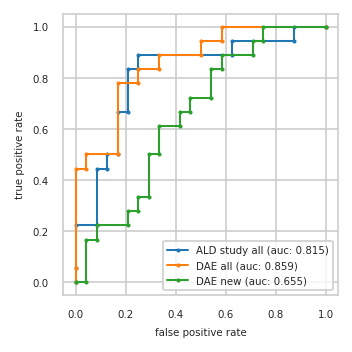

In [21]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.test, results_ald_full.name, ax)
plot_split_auc(results_model_full.test, results_model_full.name, ax)
plot_split_auc(results_model_new.test, results_model_new.name, ax)
fname = args.out_folder / 'auc_roc_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot ROC:

In [22]:
res = [results_ald_full, results_model_full, results_model_new]

auc_roc_curve = parse_roc(*res)
auc_roc_curve.to_excel(fname.with_suffix('.xlsx'))
auc_roc_curve

ALD study all       DAE all       DAE new      
             fpr   tpr     fpr   tpr     fpr   tpr
0          0.000 0.000   0.000 0.000   0.000 0.000
1          0.000 0.056   0.000 0.056   0.042 0.000
2          0.000 0.222   0.000 0.444   0.042 0.167
3          0.083 0.222   0.042 0.444   0.083 0.167
4          0.083 0.444   0.042 0.500   0.083 0.222
5          0.125 0.444   0.167 0.500   0.208 0.222
6          0.125 0.500   0.167 0.778   0.208 0.278
7          0.167 0.500   0.250 0.778   0.250 0.278
8          0.167 0.667   0.250 0.833   0.250 0.333
9          0.208 0.667   0.333 0.833   0.292 0.333
10         0.208 0.833   0.333 0.889   0.292 0.500
11         0.250 0.833   0.500 0.889   0.333 0.500
12         0.250 0.889   0.500 0.944   0.333 0.611
13         0.625 0.889   0.583 0.944   0.417 0.611
14         0.625 0.944   0.583 1.000   0.417 0.667
15         0.875 0.944   1.000 1.000   0.458 0.667
16         0.875 1.000     NaN   NaN   0.458 0.722
17         1.000 1.000     NaN   NaN   0.542 0.722
18           NaN   NaN     NaN   NaN   0.542 0.833
19           NaN   NaN     NaN   NaN   0.583 0.833
20           NaN   NaN     NaN   NaN   0.583 0.889
21           NaN   NaN     NaN   NaN   0.708 0.889
22           NaN   NaN     NaN   NaN   0.708 0.944
23           NaN   NaN     NaN   NaN   0.750 0.944
24           NaN   NaN     NaN   NaN   0.750 1.000
25           NaN   NaN     NaN   NaN   1.000 1.000

### Features selected for final models

In [23]:
selected_features = pd.DataFrame(
    [results_ald_full.selected_features,
     results_model_full.selected_features,
     results_model_new.selected_features],
    index=[
        results_ald_full.name,
        results_model_full.name,
        results_model_new.name]
).T
selected_features.index.name = 'rank'
fname = args.out_folder / 'mrmr_feat_by_model.xlsx'
files_out[fname.name] = fname
selected_features.to_excel(fname)
selected_features

,ALD study all,DAE all,DAE new
rank,,,
0,P10636-2;P10636-6,P10636-2;P10636-6,Q14894
1,P00740;P00740-2,Q99983,A0A0J9YW36;Q9NZ72;Q9NZ72-2
2,Q9NR34,O60512,F8WBF9;Q5TH30;Q9UGV2;Q9UGV2-2;Q9UGV2-3
3,Q13231;Q13231-3,P02741,Q96GD0
4,P04075,P04075,P31321
5,C9JF17;P05090,P61981,A0A075B7B8
6,P61981,Q9Y2T3;Q9Y2T3-3,A0A0C4DGV4;E9PLX3;O43504;R4GMU8
7,P14174,P14174,P51688
8,Q9Y2T3;Q9Y2T3-3,Q14894,E9PK25;G3V1A4;P23528


### Precision-Recall plot on test data

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/prec_recall_curve.pdf


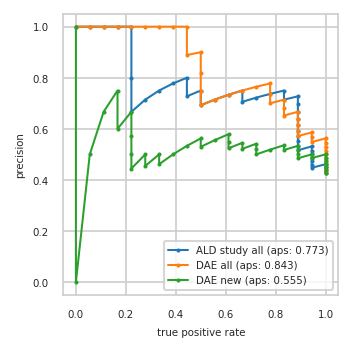

In [24]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.test, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.test, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.test, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot PRC:

In [25]:
prec_recall_curve = parse_prc(*res)
prec_recall_curve.to_excel(fname.with_suffix('.xlsx'))
prec_recall_curve

ALD study all         DAE all         DAE new      
       precision   tpr precision   tpr precision   tpr
0          0.429 1.000     0.429 1.000     0.429 1.000
1          0.439 1.000     0.439 1.000     0.439 1.000
2          0.450 1.000     0.450 1.000     0.450 1.000
3          0.462 1.000     0.462 1.000     0.462 1.000
4          0.447 0.944     0.474 1.000     0.474 1.000
5          0.459 0.944     0.486 1.000     0.486 1.000
6          0.472 0.944     0.500 1.000     0.500 1.000
7          0.486 0.944     0.514 1.000     0.486 0.944
8          0.500 0.944     0.529 1.000     0.500 0.944
9          0.515 0.944     0.545 1.000     0.485 0.889
10         0.531 0.944     0.562 1.000     0.500 0.889
11         0.516 0.889     0.548 0.944     0.516 0.889
12         0.533 0.889     0.567 0.944     0.533 0.889
13         0.552 0.889     0.586 0.944     0.517 0.833
14         0.571 0.889     0.571 0.889     0.536 0.833
15         0.593 0.889     0.593 0.889     0.519 0.778
16         0.615 0.889     0.615 0.889     0.500 0.722
17         0.640 0.889     0.640 0.889     0.520 0.722
18         0.667 0.889     0.667 0.889     0.542 0.722
19         0.696 0.889     0.652 0.833     0.522 0.667
20         0.727 0.889     0.682 0.833     0.545 0.667
21         0.714 0.833     0.714 0.833     0.524 0.611
22         0.750 0.833     0.700 0.778     0.550 0.611
23         0.737 0.778     0.737 0.778     0.579 0.611
24         0.722 0.722     0.778 0.778     0.556 0.556
25         0.706 0.667     0.765 0.722     0.529 0.500
26         0.750 0.667     0.750 0.667     0.562 0.500
27         0.733 0.611     0.733 0.611     0.533 0.444
28         0.714 0.556     0.714 0.556     0.500 0.389
29         0.692 0.500     0.692 0.500     0.462 0.333
30         0.750 0.500     0.750 0.500     0.500 0.333
31         0.727 0.444     0.818 0.500     0.455 0.278
32         0.800 0.444     0.900 0.500     0.500 0.278
33         0.778 0.389     0.889 0.444     0.444 0.222
34         0.750 0.333     1.000 0.444     0.500 0.222
35         0.714 0.278     1.000 0.389     0.571 0.222
36         0.667 0.222     1.000 0.333     0.667 0.222
37         0.800 0.222     1.000 0.278     0.600 0.167
38         1.000 0.222     1.000 0.222     0.750 0.167
39         1.000 0.167     1.000 0.167     0.667 0.111
40         1.000 0.111     1.000 0.111     0.500 0.056
41         1.000 0.056     1.000 0.056     0.000 0.000
42         1.000 0.000     1.000 0.000     1.000 0.000

## Train data plots

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/prec_recall_curve_train.pdf


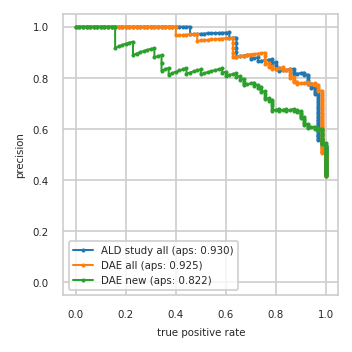

In [26]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.train, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.train, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/auc_roc_curve_train.pdf


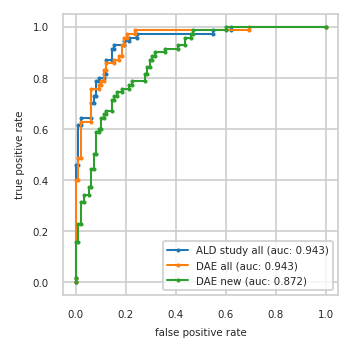

In [27]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.train, results_ald_full.name, ax)
plot_split_auc(results_model_full.train, results_model_full.name, ax)
plot_split_auc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'auc_roc_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Output files:

In [28]:
files_out

{'results_DAE all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/results_DAE all.pkl'),
 'results_DAE new.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/results_DAE new.pkl'),
 'results_ALD study all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/results_ALD study all.pkl'),
 'auc_roc_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/auc_roc_curve.pdf'),
 'mrmr_feat_by_model.xlsx': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/mrmr_feat_by_model.xlsx'),
 'prec_recall_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/prec_recall_curve.pdf'),
 'prec_recall_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/prec_recall_curve_train.pdf'),
 'auc_roc_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/auc_roc_curve_train.pdf')}